#### CUDA SETTINGS

In [15]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#### IMPORTS

In [16]:
from reproduce.reproduce_utils import call_cfg_key, reconstruct_from_config, eval_ose, plot_results
from omegaconf import OmegaConf
import datetime
from tqdm import tqdm

#### IMPORTANT FILE PATHS

In [3]:
# downloaded cmems data
concatenated_6_nadirs_filepath = "/DATASET/OCB_traces/input_test_6sat_2022_global.nc"
test_1_nadir_filepath = "/DATASET/OCB_traces/concat/concatenated_ref_2022_reprocessed.nc"

# model hydra config
your_config = 'reproduce/config.yaml'
# best model ckpt path
best_ckpt_path = '/homes/p24hasle/repos/4dvarnet-starter-glorys12/outputs/2024-09-01/00-26-24/base_forecast_global/checkpoints/val_mse=59.39316-epoch=265.ckpt'
# name of the dir under which the reconstructed files will be stored
your_rec_dir = 'rec_ose_global_masking_MP'

# reconstructed files will be stored in <your_rec_dir>/reproduce/version_0/
# careful, it will be version_1, 2, 3... instead of version_0 and so on if you use this notebook multiple times
REC_PATHS = '/DATASET/GLORYS12/outputs/'+your_rec_dir+'/reproduce/version_0/test_data_{}.nc'

#### CONFIG OVERRIDES

In [4]:
# min and max time of REFERENCE DATA
min_time = '2022-03-01'
max_time = '2022-04-30'

In [5]:
min_time_date = datetime.datetime.strptime(min_time, '%Y-%m-%d')
max_time_date = datetime.datetime.strptime(max_time, '%Y-%m-%d')

time_offset = datetime.timedelta(days=1)

min_time_offset = min_time_date + time_offset
max_time_offset = max_time_date - time_offset

min_time_offset_str = min_time_offset.strftime('%Y-%m-%d')
max_time_offset_str = max_time_offset.strftime('%Y-%m-%d')

print('min/max time: {} / {}\nmin/max offseted time: {} / {}'.format(min_time, max_time, min_time_offset_str, max_time_offset_str))

min/max time: 2022-03-01 / 2022-04-30
min/max offseted time: 2022-03-02 / 2022-04-29


#### LOADING CONFIG

In [6]:
config = OmegaConf.load(your_config)
#OmegaConf.set_struct(config, True)

# override path to cmems input data
OmegaConf.update(config, key='paths.ose_6_sats', value=concatenated_6_nadirs_filepath)

# override time necessary time values in config
OmegaConf.update(config, key='datamodule.domains.train.time._args_', value=[min_time, min_time_offset_str])
OmegaConf.update(config, key='datamodule.domains.val.time._args_', value=[min_time, min_time_offset_str])
#full_time allocated to the test dataset
OmegaConf.update(config, key='datamodule.domains.test.time._args_', value=[min_time, max_time])
OmegaConf.update(config, key='datamodule.input_da.test_cut._target_', value='builtins.slice')
OmegaConf.update(config, key='datamodule.input_da.test_cut._args_', value=[min_time, max_time])
# pre metric fn is applied to a a window cropped on each side by 15 days
OmegaConf.update(config, key='model.pre_metric_fn.time._args_', value=[min_time_offset_str, max_time_offset_str])

### PREDICT WITH MODEL:

In [ ]:
reconstruct_from_config(config, your_rec_dir, best_ckpt_path)

### OSE RESULTS:

In [6]:
lead_times = range(13,20)

RMSE_array = []

for lead_time in tqdm(lead_times):
    a,b = eval_ose(
        path_alongtrack = test_1_nadir_filepath,
        path_rec = REC_PATHS.format(lead_time),
        time_min = min_time_offset_str,
        time_max= max_time_offset_str,
        lon_min=-179,
        lon_max=179,
        lat_min=-79,
        lat_max=89,
        #lon_min=-65,
        #lon_max=-55,
        #lat_min=32,
        #lat_max=42
    )

    print('leadtime {} - RMSE: {:.4f} | PSD: {:.4f}'.format(lead_time, a, b))
    RMSE_array.append(a)

 14%|█▍        | 1/7 [00:08<00:50,  8.34s/it]

478.9553286159635
leadtime 13 - RMSE: 0.8842 | PSD: 478.9553


 29%|██▊       | 2/7 [00:15<00:37,  7.53s/it]

322.2883188942997
leadtime 14 - RMSE: 0.8999 | PSD: 322.2883


 43%|████▎     | 3/7 [00:22<00:28,  7.20s/it]

307.43723769869143
leadtime 15 - RMSE: 0.8702 | PSD: 307.4372


 57%|█████▋    | 4/7 [00:28<00:21,  7.07s/it]

452.95187208482866
leadtime 16 - RMSE: 0.8613 | PSD: 452.9519


 71%|███████▏  | 5/7 [00:35<00:13,  7.00s/it]

452.89626052769415
leadtime 17 - RMSE: 0.8584 | PSD: 452.8963


 86%|████████▌ | 6/7 [00:42<00:06,  6.91s/it]

457.8660541688754
leadtime 18 - RMSE: 0.8593 | PSD: 457.8661


100%|██████████| 7/7 [00:49<00:00,  7.05s/it]

401.33369495210644
leadtime 19 - RMSE: 0.8660 | PSD: 401.3337


In [11]:
from IPython.display import display, Markdown

def show_metrics(metrics_dict, model_name='METRICS'):
    to_show = '## {}\n\n'.format(model_name)

    for domain_name, domain_metrics in metrics_dict.items():
        n = len(next(iter(domain_metrics.values())))
        to_show += '<details>\n<summary>{}</summary>'.format(domain_name.upper())
        to_show += '\n\n\n|LEADTIME|' + ''.join('{}|'.format(leadtime) for leadtime in range(n))
        to_show += '\n|---|' + ''.join('---|'for i in range(n))
        for metric_name, metric_values in domain_metrics.items():
            to_show += '\n|{}|'.format(metric_name) + ''.join('{:.3f}|'.format(rmse_score) for rmse_score in metric_values)
        to_show += '\n\n\n</details>'

    display(Markdown(to_show))

In [12]:
metrics = {'Global': {'nRMSE': []}}
for rmse in RMSE_array:
    metrics['Global']['nRMSE'].append(rmse)

show_metrics(metrics)

## METRICS

<details>
<summary>GLOBAL</summary>


|LEADTIME|0|1|2|3|4|5|6|
|---|---|---|---|---|---|---|---|
|nRMSE|0.884|0.900|0.870|0.861|0.858|0.859|0.866|


</details>

#### PLOT RESULTS

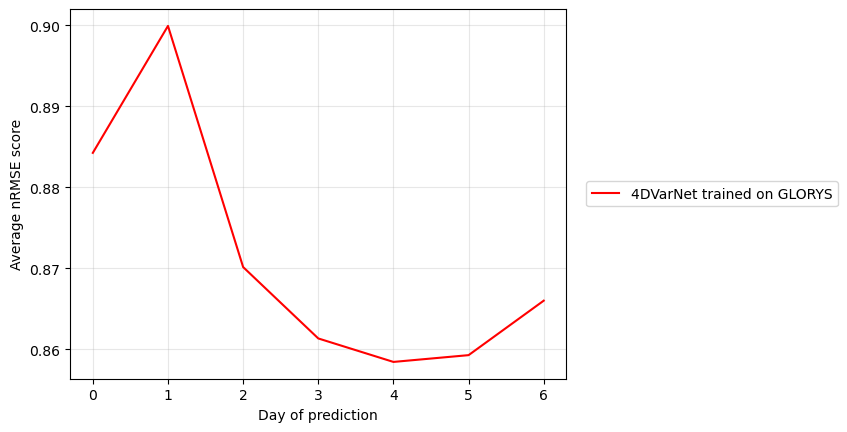

In [14]:
# save_name: named of saved graph if not None
plot_results(RMSE_array, save_name=None, plot_baked=False, vmin=0., vmax=1., name='Globe MASK + MovPatch')